In [1]:
import stackstac

In [ ]:
!pip install stackstac

In [2]:
lon, lat = -105.75, 35.79

In [3]:
import pystac_client

In [4]:
url = "https://earth-search.aws.element84.com/v1"
catalog = pystac_client.Client.open(url)

In [5]:
%%time
items = catalog.search(
    intersects = dict(type="Point", coordinates=[lon, lat]),
    collections=["sentinel-2-l2a"],
    datetime="2020-03-01/2020-06-01"
).item_collection()
len(items)

CPU times: user 180 ms, sys: 14.1 ms, total: 194 ms
Wall time: 8.18 s


72

In [6]:
%time stack = stackstac.stack(items)

CPU times: user 68.7 ms, sys: 930 µs, total: 69.6 ms
Wall time: 68.8 ms


/home/jay/miniconda3/envs/geospatial/lib/python3.10/site-packages/stackstac/prepare.py:408: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  times = pd.to_datetime(


In [7]:
stack

<xarray.DataArray 'stackstac-fcaea754d474c96df942ee8dbc7f6d3e' (time: 72,
                                                                band: 32,
                                                                y: 10980,
                                                                x: 10980)>
dask.array<fetch_raster_window, shape=(72, 32, 10980, 10980), dtype=float64, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/52)
  * time                                     (time) datetime64[ns] 2020-03-02...
    id                                       (time) <U24 'S2B_13SDV_20200302_...
  * band                                     (band) <U12 'aot' ... 'wvp-jp2'
  * x                                        (x) float64 4e+05 ... 5.098e+05
  * y                                        (y) float64 4e+06 ... 3.89e+06
    mgrs:utm_zone                            int64 13
    ...                                       ...
    raster:bands                             (band) object [{'nodata': 0, 'da...
    gsd                                      (band) object None 10 ... None None
    common_name                              (band) object None 'blue' ... None
    center_wavelength                        (band) object None 0.49 ... None
    full_width_half_max                      (band) object None 0.098 ... None
    epsg                                     int64 32613
Attributes:
    spec:        RasterSpec(epsg=32613, bounds=(399960.0, 3890220.0, 509760.0...
    crs:         epsg:32613
    transform:   | 10.00, 0.00, 399960.00|\n| 0.00,-10.00, 4000020.00|\n| 0.0...
    resolution:  10.0

In [8]:
lowcloud = stack[stack["eo:cloud_cover"] < 20]
rgb = lowcloud.sel(band=["red", "green", "blue"])
monthly = rgb.resample(time="MS").median("time", keep_attrs=True)

In [9]:
monthly

<xarray.DataArray 'stackstac-fcaea754d474c96df942ee8dbc7f6d3e' (time: 3,
                                                                band: 3,
                                                                y: 10980,
                                                                x: 10980)>
dask.array<stack, shape=(3, 3, 10980, 10980), dtype=float64, chunksize=(1, 1, 915, 915), chunktype=numpy.ndarray>
Coordinates: (12/21)
  * band                                     (band) <U12 'red' 'green' 'blue'
  * x                                        (x) float64 4e+05 ... 5.098e+05
  * y                                        (y) float64 4e+06 ... 3.89e+06
    mgrs:utm_zone                            int64 13
    mgrs:latitude_band                       <U1 'S'
    s2:product_type                          <U7 'S2MSI2A'
    ...                                       ...
    gsd                                      (band) object 10 10 10
    common_name                              (band) object 'red' 'green' 'blue'
    center_wavelength                        (band) object 0.665 0.56 0.49
    full_width_half_max                      (band) object 0.038 0.045 0.098
    epsg                                     int64 32613
  * time                                     (time) datetime64[ns] 2020-03-01...
Attributes:
    spec:        RasterSpec(epsg=32613, bounds=(399960.0, 3890220.0, 509760.0...
    crs:         epsg:32613
    transform:   | 10.00, 0.00, 399960.00|\n| 0.00,-10.00, 4000020.00|\n| 0.0...
    resolution:  10.0

In [10]:
import pyproj
x_utm, y_utm = pyproj.Proj(monthly.crs)(lon, lat)
buffer = 2000

In [12]:
aoi = monthly.loc[..., y_utm+buffer:y_utm-buffer,x_utm-buffer:x_utm+buffer]
aoi

<xarray.DataArray 'stackstac-fcaea754d474c96df942ee8dbc7f6d3e' (time: 3,
                                                                band: 3,
                                                                y: 400, x: 400)>
dask.array<getitem, shape=(3, 3, 400, 400), dtype=float64, chunksize=(1, 1, 385, 355), chunktype=numpy.ndarray>
Coordinates: (12/21)
  * band                                     (band) <U12 'red' 'green' 'blue'
  * x                                        (x) float64 4.302e+05 ... 4.342e+05
  * y                                        (y) float64 3.963e+06 ... 3.959e+06
    mgrs:utm_zone                            int64 13
    mgrs:latitude_band                       <U1 'S'
    s2:product_type                          <U7 'S2MSI2A'
    ...                                       ...
    gsd                                      (band) object 10 10 10
    common_name                              (band) object 'red' 'green' 'blue'
    center_wavelength                        (band) object 0.665 0.56 0.49
    full_width_half_max                      (band) object 0.038 0.045 0.098
    epsg                                     int64 32613
  * time                                     (time) datetime64[ns] 2020-03-01...
Attributes:
    spec:        RasterSpec(epsg=32613, bounds=(399960.0, 3890220.0, 509760.0...
    crs:         epsg:32613
    transform:   | 10.00, 0.00, 399960.00|\n| 0.00,-10.00, 4000020.00|\n| 0.0...
    resolution:  10.0

In [13]:
data = aoi.compute()

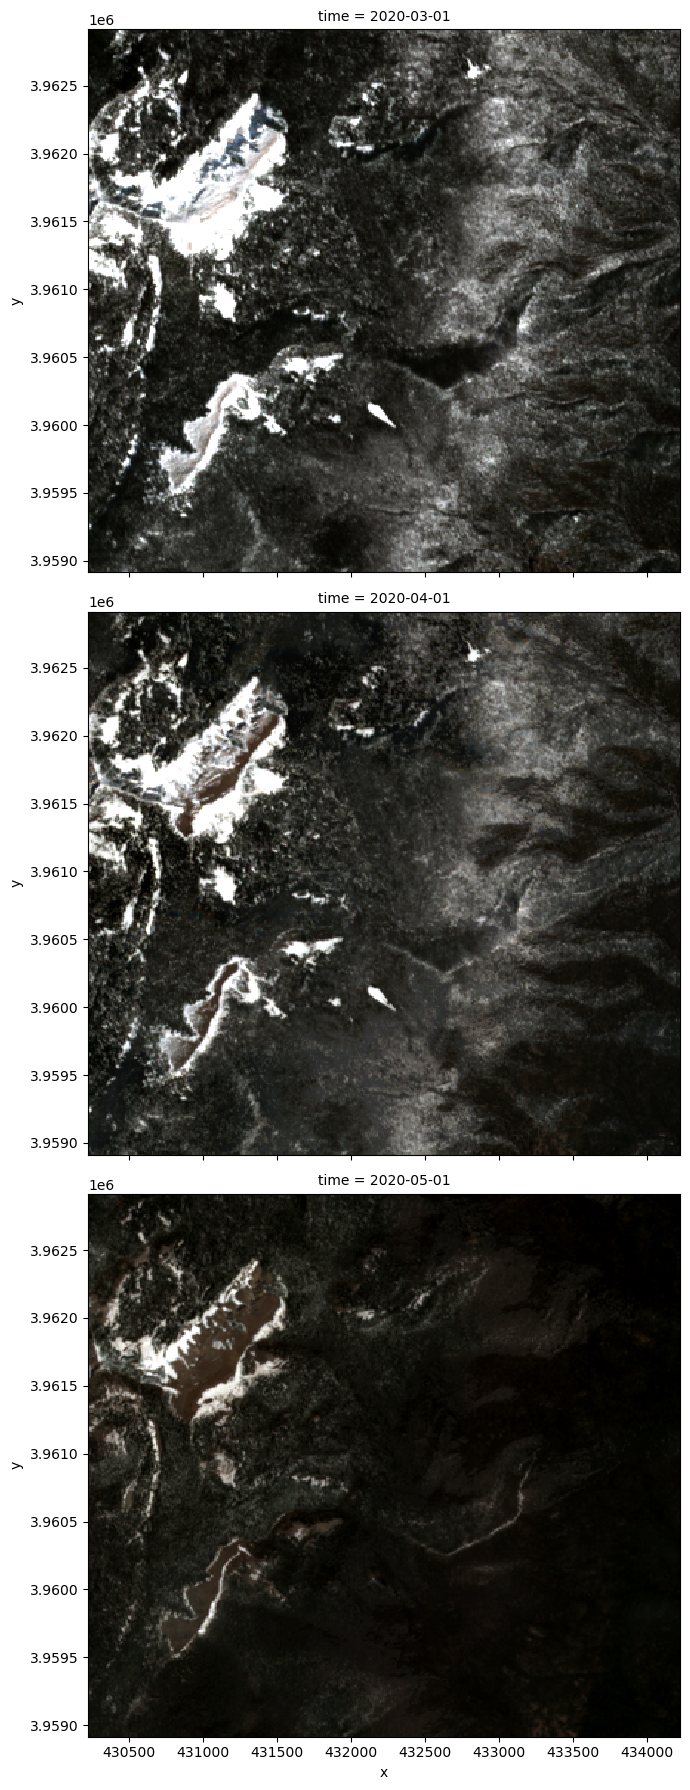

In [14]:
data.plot.imshow(row="time", rgb="band", robust=True, size=6)